In [1]:
# Read hot comments from hotCommentsFromUsers.csv
import pandas as pd

hot_comments_df = pd.read_csv('hotCommentsFromUsers.csv')

hot_comments_df.head(5)

C:\Users\26553\AppData\Local\Temp\ipykernel_6780\3323965709.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  hot_comments_df = pd.read_csv('hotCommentsFromUsers.csv')


,comment_id,link_id,subreddit,parent_id,redditor_id,created_at,body,score,edited,removed
0,l36kipr,1cmy9mm,ArtistLounge,t3_1cmy9mm,4pt94,2024-05-08 22:21:22+00,I think beginner artists should stop posting t...,"{""2024-05-12T00:00:57"":4}",False,NaN
1,l37k71y,1cnc2m2,mildlyinteresting,t1_l36trtq,4pt94,2024-05-09 01:59:19+00,Everyone has had that experience. It's weird b...,"{""2024-05-12T00:00:58"":0}",False,NaN
2,l37jvzb,1cnc2m2,mildlyinteresting,t1_l37gsw6,4pt94,2024-05-09 01:57:14+00,Look I'm speaking collectively about the prais...,"{""2024-05-12T00:00:59"":-2}",False,NaN
3,l37dtf5,1cnc2m2,mildlyinteresting,t1_l365mpu,4pt94,2024-05-09 01:16:40+00,Oh my God is that why you dweebs are applaudin...,"{""2024-05-12T00:01:00"":-7}",False,NaN
4,l33v9tz,1cme9ka,DigitalArt,t1_l32xj76,4pt94,2024-05-08 11:30:07+00,No that's illegal,"{""2024-05-12T00:01:01"":1}",False,NaN


In [2]:
unique_subreddits = list(hot_comments_df['subreddit'].unique())

print('Number of unique subreddits:', len(unique_subreddits))

# Group by redditor_id and count the number of comments each redditor has made
redditor_comment = hot_comments_df.groupby('redditor_id')

# For each redditor, get a list of the subreddits they have commented in in a list
redditor_subreddits = redditor_comment['subreddit'].unique()
redditor_subreddits_dict = redditor_subreddits.to_dict()

print('Number of redditors', len(redditor_subreddits_dict))

Number of unique subreddits: 14301
Number of redditors 10741


In [3]:
redditor_subreddits_indices_dict = {}
for redditor, subreddits in redditor_subreddits_dict.items():
    indices = [unique_subreddits.index(subreddit) for subreddit in subreddits]
    redditor_subreddits_indices_dict[redditor] = indices


# Indices to bow
import numpy as np

def indices_to_bow(indices, n, normalize='none'):
    bow = np.zeros(n)
    for index in indices:
        bow[index] += 1
    if normalize == 'l2':
        bow = bow / np.linalg.norm(bow)
    elif normalize == 'l1':
        bow = bow / np.sum(bow)
    return bow

redditor_bows = {}
for redditor, indices in redditor_subreddits_indices_dict.items():
    bow = indices_to_bow(indices, len(unique_subreddits), normalize='l1')
    redditor_bows[redditor] = bow


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

def jacard_similarity(bow1, bow2):
    intersection = np.sum(np.minimum(bow1, bow2))
    union = np.sum(np.maximum(bow1, bow2))
    return intersection / union

def jacard_similarity_matrix(bows):
    n = len(bows)
    similarity_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i, n):
            similarity_matrix[i, j] = jacard_similarity(bows[i], bows[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]
    return similarity_matrix

# Calculate cosine similarity
redditor_ids = list(redditor_bows.keys())
redditor_bows_matrix = np.array(list(redditor_bows.values()))

similarity_matrix = jacard_similarity_matrix(redditor_bows_matrix)

# Save similarity matrix
np.save('redditor_jacard_similarity_matrix.npy', similarity_matrix)


100%|██████████| 10741/10741 [35:04<00:00,  5.10it/s] 


In [34]:
# Construct graph
import networkx as nx

# Convert similarity matrix to adjacency matrix with a threshold
threshold = 0.05
adjacency_matrix = (similarity_matrix > threshold).astype(int)
G = nx.Graph(adjacency_matrix)

#G = nx.Graph()

#for i, redditor_id in enumerate(redditor_ids):
#    G.add_node(i)
#    for j, similarity in enumerate(similarity_matrix[i]):
#        if i != j and similarity > threshold:
#            G.add_edge(redditor_id, redditor_ids[j], weight=similarity)


In [35]:
# Community detection
from networkx.algorithms import community

communities = community.louvain_communities(G)

print('Number of communities:', len(communities))

Number of communities: 100


100%|██████████| 16/16 [07:41<00:00, 28.83s/it]


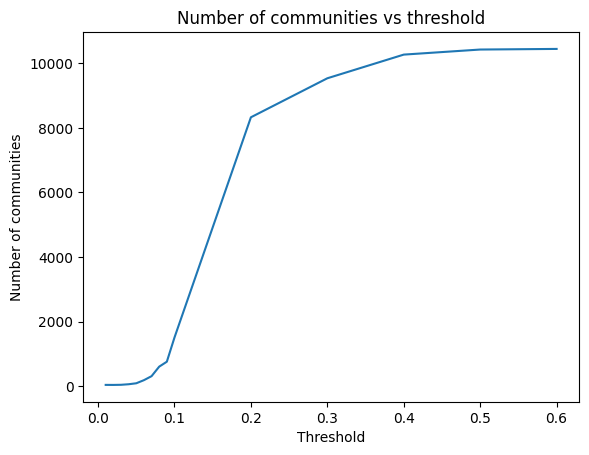

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import numpy as np
from tqdm import tqdm

def test_louvain(threshold):
    adjacency_matrix = (similarity_matrix > threshold).astype(int)
    G = nx.Graph(adjacency_matrix)
    communities = community.louvain_communities(G)
    return len(communities)

thresholds = list(np.linspace(0.01, 0.1, 10)) + list(np.linspace(0.1, 0.6, 6))

num_communities = []
for threshold in tqdm(thresholds):
    num_communities.append(test_louvain(threshold))


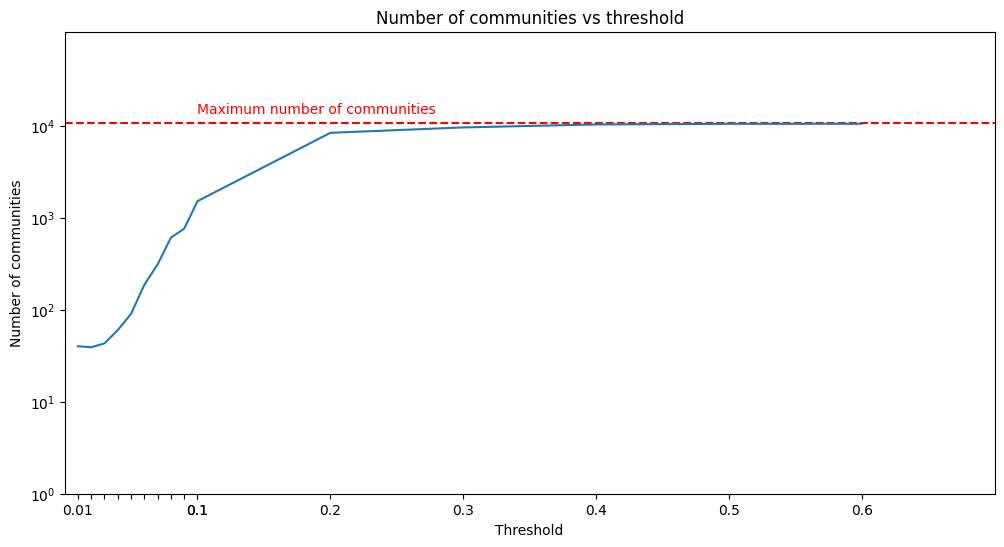

In [24]:
# Plot the thresholds and num_communities with numbers
import matplotlib.pyplot as plt

log_num_communities = np.log10(num_communities)

plt.figure(figsize=(12, 6))
#for i in range(len(thresholds)):
#    plt.text(thresholds[i], num_communities[i], f'{num_communities[i]}', fontsize=4, ha='right')
plt.xlim(0, max(thresholds) + 0.1)  # Adding a small buffer for better visibility
plt.ylim(0, max(log_num_communities) + 1)  # Adding a small buffer for better visibility
plt.xticks(thresholds, labels=['0.01', '', '', '', '', '', '', '', '', '0.1', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'])

plt.yticks(range(int(max(log_num_communities)) + 1), labels=[f'$10^{i}$' for i in range(int(max(log_num_communities)) + 1)])

# Draw a horizontal line at y = np.log10(10751) as maximum number of communities
plt.axhline(y=np.log10(10751), color='r', linestyle='--')
plt.text(0.1, np.log10(10751) + 0.1, 'Maximum number of communities', color='r')

plt.plot(thresholds, log_num_communities)
plt.xlabel('Threshold')
plt.ylabel('Number of communities')
plt.title('Number of communities vs threshold')
plt.show()


In [36]:
def collapse_communities(communities):
    collapsed_communities = []
    outliers = []
    for comm in communities:
        if len(comm) > 1:
            collapsed_communities.append(list(comm))
        else:
            outliers.extend(list(comm))

    collapsed_communities.append(outliers)
    return collapsed_communities

communities = collapse_communities(communities)
print('Number of collapsed communities:', len(communities))

redditor_communities = {}
for i, comm in enumerate(communities):
    for redditor_id in comm:
        redditor_communities[redditor_ids[redditor_id]] = i

redditor_communities    

Number of collapsed communities: 18


{'l1rdk': 0,
 'l24ofkh1': 0,
 'l25rhcu6': 0,
 'l2ka6v1h': 0,
 '106s0m': 0,
 'l3dejihk0': 0,
 '107gn9': 0,
 '107m9l': 0,
 '107yga': 0,
 '108yp75d': 0,
 'l5kcv8fn': 0,
 'l5zlayab': 0,
 '109j3n': 0,
 'l6aun': 0,
 'l7bkd': 0,
 'l7f6f4vnz': 0,
 'l8a7a': 0,
 'l8kdp84n': 0,
 'l8xecc8e': 0,
 'l9qatscow': 0,
 'l9vm6': 0,
 'lakosik': 0,
 '10o1nw': 0,
 'lbs81aj8': 0,
 '10r5zr': 0,
 '10tlne': 0,
 'lecunoa8': 0,
 'lfncg': 0,
 '10zyr20u': 0,
 '110k7y': 0,
 'lgaygfqh': 0,
 'lhknrglb': 0,
 '119ix2': 0,
 'li70bj56': 0,
 'lihdy': 0,
 '11bahgxe': 0,
 'liqjo6mj': 0,
 '11bf45': 0,
 'ljaabzj': 0,
 '11ch9d': 0,
 '11czwa': 0,
 'ljwv4xff1': 0,
 'ljxzwrp': 0,
 '11ekr4': 0,
 'llxrc9xs': 0,
 'lm2sjc4ek': 0,
 'lm8t0bf0': 0,
 'lmk1lyeu': 0,
 'lnk2b0qe': 0,
 'lnwfwsqy': 0,
 'lo2zdzfwh': 0,
 '11h7jj': 0,
 '11hfzu65': 0,
 '11j5af': 0,
 '11jdll': 0,
 '11khd1mi': 0,
 'lrx8hsgw': 0,
 '11lmay': 0,
 'ls18s75e': 0,
 'ls3ru7mmi': 0,
 '11p2pd1n': 0,
 '11phf3': 0,
 'lusi9': 0,
 'lv93dhf6o': 0,
 '11qwk1': 0,
 '11rc56': 0,
 'lwd

In [39]:
# Count how many redditors are in each community
redditors_in_communities = {}
for redditor_id, community_id in redditor_communities.items():
    if community_id not in redditors_in_communities:
        redditors_in_communities[community_id] = 0
    redditors_in_communities[community_id] += 1

redditors_in_communities

{0: 2178,
 1: 2,
 2: 484,
 3: 4189,
 4: 2,
 5: 2,
 6: 173,
 7: 3,
 8: 2,
 9: 2,
 10: 2,
 11: 624,
 12: 4,
 13: 2,
 14: 2985,
 15: 2,
 16: 2,
 17: 83}

In [40]:
# Show top n subreddits in each cluster
top_n = 5

cluster_subreddits = {}
for cluster in range(len(communities)):
    redditors_in_cluster = [redditor for redditor, cluster_num in redditor_communities.items() if cluster_num == cluster]
    cluster_subreddits[cluster] = [unique_subreddits[index] for index in np.argsort(np.sum([redditor_bows[redditor] for redditor in redditors_in_cluster], axis=0))[-top_n:]]

cluster_subreddits

{0: ['ChatGPT', 'DefendingAIArt', 'singularity', 'StableDiffusion', 'aiwars'],
 1: ['cartoons', 'BatmanArkham', 'discordVideos', 'whenthe', 'lies'],
 2: ['explainlikeimfive',
  'AmItheAsshole',
  'unpopularopinion',
  'NoStupidQuestions',
  'changemyview'],
 3: ['Games', 'Helldivers', 'movies', 'worldnews', 'technology'],
 4: ['magicthecirclejerking',
  'WinStupidPrizes',
  'NSFL__',
  'shitposting',
  'TattooApprentice'],
 5: ['gamecollecting',
  'AntiFursInAction',
  'TokyoAfterschool',
  'ArtistHate',
  'ClipStudio'],
 6: ['MercyMains', 'LivestreamFail', 'KingdomHearts', 'neoliberal', 'Destiny'],
 7: ['TheGirlSurvivalGuide',
  'shoujo',
  'MakeupAddiction',
  'AsianBeauty',
  '30PlusSkinCare'],
 8: ['warhawk',
  'psytrance',
  'FuckStuartLittle',
  'SakisanNoBashitsu',
  'Slovakia'],
 9: ['memes',
  'UNSUBSCRIBEpodcast',
  'tooktoomuch',
  'PhilosophyMemes',
  'terriblefacebookmemes'],
 10: ['mensa',
  'cringepics',
  'ShittyLifeProTips',
  'RaybanMeta',
  'RayBanStories'],
 11: ['b